## POSTPROECESSING

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import genus as gn
from genus.util import load_obj

In [4]:
tiling_file = "./tiling_large.pt"
tiling = load_obj(tiling_file)

In [5]:
print(tiling._fields)
for f in tiling._fields:
    print(f, type(getattr(tiling,f)))

('raw_image', 'fg_prob', 'integer_mask', 'bounding_boxes', 'similarity')
raw_image <class 'torch.Tensor'>
fg_prob <class 'torch.Tensor'>
integer_mask <class 'torch.Tensor'>
bounding_boxes <class 'NoneType'>
similarity <class 'MODULES.namedtuple.SparseSimilarity'>


### Show the segmentation before the graph approach

In [6]:
from genus.util_vis import plot_img_contours_label

[2488, 1520, 2688, 1720]


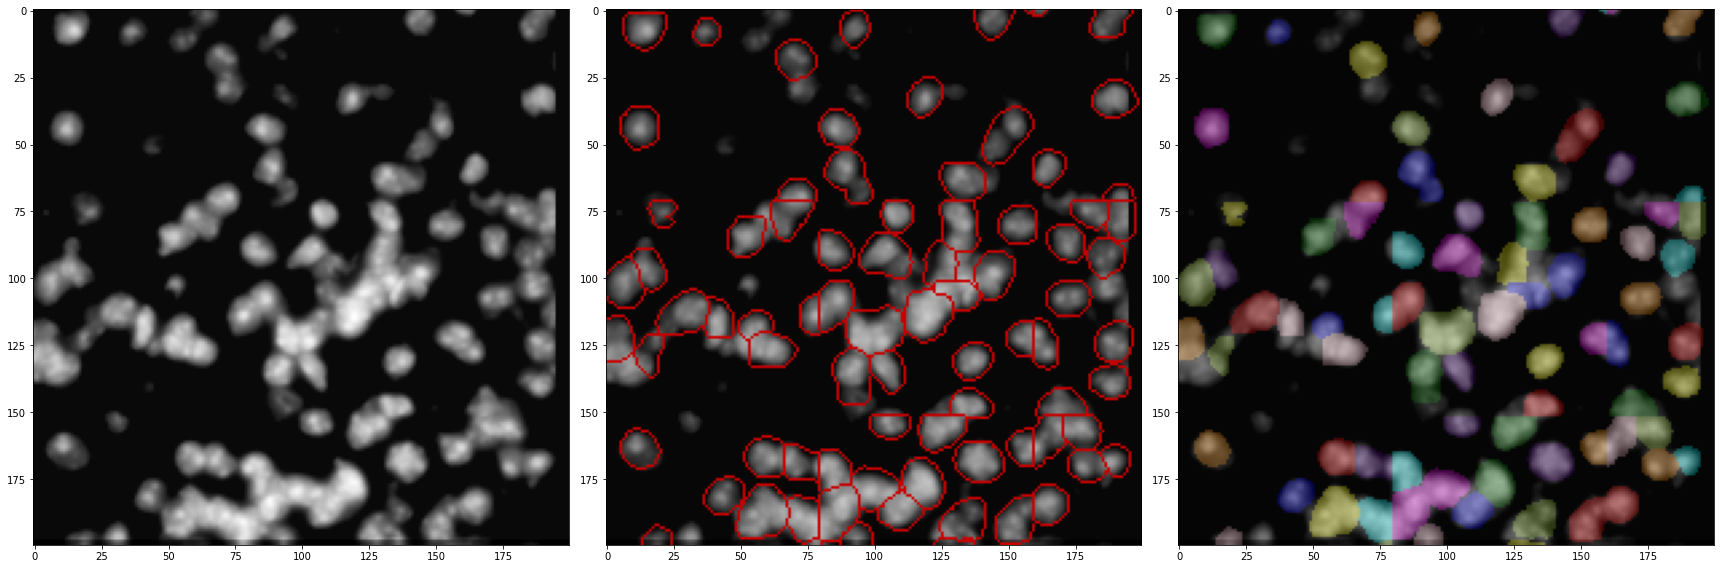

In [7]:
ix, iy, delta = 2488, 1520, 200
window = [ix, iy, ix+delta, iy+delta]

plot_img_contours_label(image=tiling.raw_image[0],
                        label=tiling.integer_mask[0,0],
                        window=window,
                        contour_thickness=1,
                        contour_color='red')

In [14]:
from genus.namedtuple import Segmentation, SparseSimilarity

tiling_v2 = Segmentation(raw_image=tiling.raw_image,
                         fg_prob=tiling.fg_prob,
                         integer_mask=tiling.integer_mask,
                         bounding_boxes=tiling.bounding_boxes,
                         bounding_boxes_ideal=None,
                         similarity=tiling.similarity)


sp_v2 = SparseSimilarity(sparse_matrix=tiling.similarity.sparse_matrix,
                         index_matrix=tiling.similarity.index_matrix)


small_tiling = tiling_v2.filter_by_window(window=(ix,iy,ix+delta,iy+delta))
#small_sp = sp_v2.filter_by_window(window=(ix,iy,ix+delta,iy+delta))


### Do a graph approach

In [70]:
from genus.graph_clustering import GraphSegmentation, filter_labels_by_size

In [71]:
g = GraphSegmentation(segmentation=small_tiling)

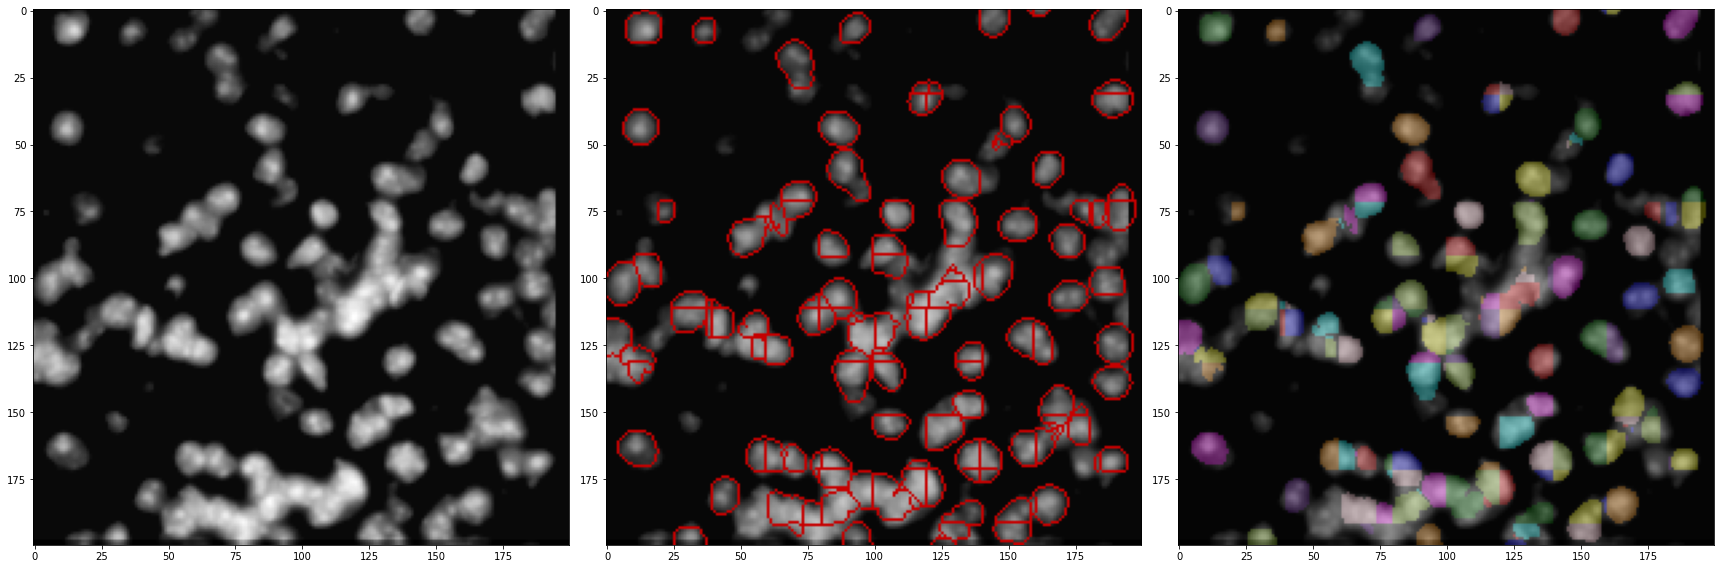

In [79]:
partition = g.partition(edge_threshold=0.8,
                        min_cluster_size=2,
                        min_fg_prob=0.1,
                        min_edge_weight=0.01)

int_mask = g.partition_2_integer_mask(partition)
#plt.imshow(int_mask)

plot_img_contours_label(image=small_tiling.raw_image[0],
                        label=int_mask,
                        contour_thickness=1,
                        contour_color='red')

### Debug the minimum spanning tree

created graph
32 tensor([ 176,  129,   22,  170,  132,  114,  254,  159,  183, 3513,  168,  179,
         253,  152,  538, 1364,  116,  174,  152,  170,  364,   84, 1313,  258,
         605,  880,  196, 2298,  261,  404,  304,  180])


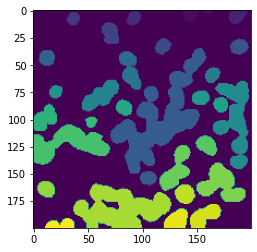

In [52]:
import scipy, torch
from genus.graph_clustering import torch_2_csr

graph = g._similarity_2_graph(min_fg_prob=0.1, min_edge_weight=0.01)

# this is a test that connect component work
n_components, labels = scipy.sparse.csgraph.connected_components(torch_2_csr(graph), 
                                                                 directed=True,
                                                                 connection='weak',
                                                                 return_labels=True)
torch_labels = torch.from_numpy(labels).long()
int_mask = g.partition_2_integer_mask(torch_labels)
print(n_components, torch.bincount(torch_labels))
plt.imshow(int_mask)

32 tensor([ 176,  129,   22,  170,  132,  114,  254,  159,  183, 3513,  168,  179,
         253,  152,  538, 1364,  116,  174,  152,  170,  364,   84, 1313,  258,
         605,  880,  196, 2298,  261,  404,  304,  180])


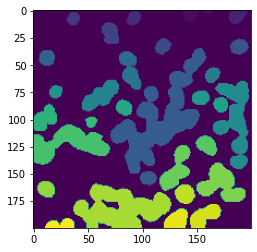

In [53]:
maximum_spanning_tree = g._compute_maximum_spanning_tree(min_fg_prob=0.1, min_edge_weight=0.01)
    
n_components, labels = scipy.sparse.csgraph.connected_components(maximum_spanning_tree, 
                                                                 directed=True,
                                                                 connection='weak',
                                                                 return_labels=True)
torch_labels = torch.from_numpy(labels).long()
int_mask = g.partition_2_integer_mask(torch_labels)
print(n_components, torch.bincount(torch_labels))
plt.imshow(int_mask)



In [ ]:
cc = scipy.sparse.csgraph.connected_components(maximum_spanning_tree,
                                                                 directed=True,
                                                                 connection='weak',
                                                                 return_labels=True)

In [ ]:

n_components, labels = scipy.sparse.csgraph.connected_components(maximum_spanning_tree,
                                                                 directed=True,
                                                                 connection='weak',
                                                                 return_labels=True)

In [23]:
print(int_mask.shape)

torch.Size([200, 200])


In [22]:
print(partition)

tensor([   1,    2,    3,  ..., 2776, 2776, 2778])


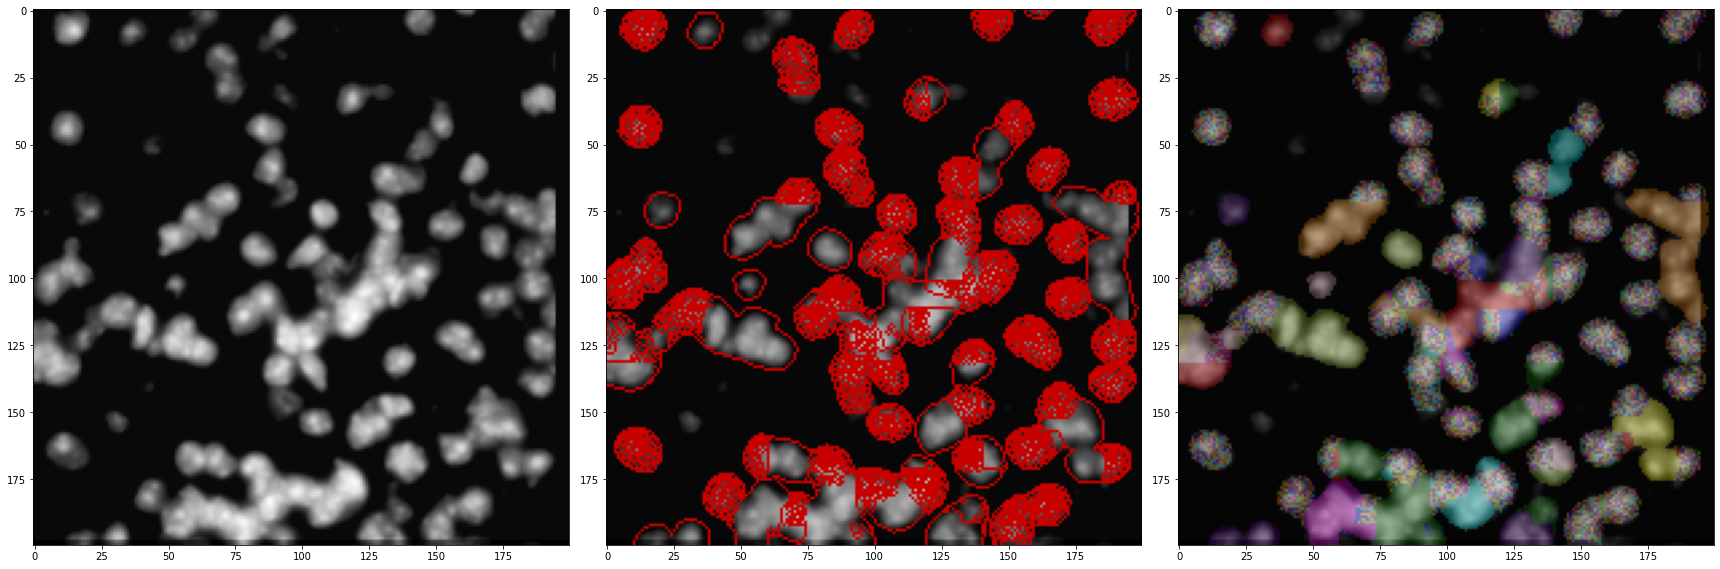

In [24]:
plot_img_contours_label(image=small_tiling.raw_image[0],
                        label=int_mask,
                        contour_thickness=1,
                        contour_color='red')

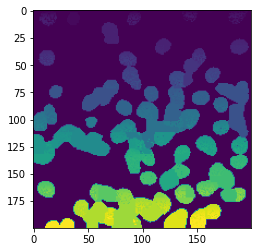

In [21]:
plt.imshow(int_mask)

In [ ]:
int_mask.shape

In [ ]:
tiling._fields

In [ ]:
plot_img_contours_label(image=tiling.raw_image[0],
                        label=int_mask,
                        window=window,
                        contour_thickness=1,
                        contour_color='red')

In [ ]:
plt.imshow(int_mask[ix:ix+delta,iy:iy+delta])

In [ ]:
partition

In [ ]:
import torch
plt.plot(torch.bincount(p1)[1:])



In [ ]:
print(tiling.similarity._fields)
a = tiling.similarity.sparse_matrix.coalesce() 
_ = plt.hist(a.values(), bins=20, density=True)

In [ ]:
from genus.graph_clustering import torch_2_csr_matrix, csr_matrix_2_torch
csr = torch_2_csr_matrix(a)
a2 = csr_matrix_2_torch(csr)

### Get the complementary matrix

In [ ]:
csr

In [ ]:
a

In [ ]:
a._nnz()

In [ ]:
a.ndim

In [ ]:
coo = csr.tocoo()

In [ ]:
coo.

In [ ]:
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import isspmatrix

csr = torch_to_csr_matrix(b)
tree = minimum_spanning_tree(csr)
print(isspmatrix(tree))

In [ ]:
from scipy.sparse.csgraph import connected_components

tree_filtered = (tree > 0.5)
n_components, labels = connected_components(csgraph=tree_filtered, directed=True, connection='weak', return_labels=True)

In [ ]:
tree

In [ ]:
n_components

In [ ]:
csr

In [ ]:
tree

In [ ]:
tree_filtered

In [ ]:
FILTER THE EDGES AND PLOT THE CONNECTED COMPONENTS


In [ ]:
csr

In [ ]:
tree

In [ ]:
tuple(a.size())

In [ ]:
import numpy as np
row  = np.array([0, 3, 1, 0])
col  = np.array([0, 3, 1, 2])
data = np.array([4, 5, 7, 9])
coo_matrix((data, (row, col)), shape=(4, 4)).toarray()



In [ ]:
b = sparse_complementary(a)
_ = plt.hist(b.values(), bins=20, density=True)

In [ ]:
#coo = torch_to_coo_matrix(b)


In [ ]:
csr

In [ ]:
type(coo)

### On CPU use scipy to get the minimum spanning tree

In [ ]:
a.indices().shape

In [ ]:
b.values()

In [ ]:
a.values()

In [ ]:
a.size()

In [ ]:
a

In [ ]:
import torch
b.values = (1.0 - a.values().clone().detach())

In [ ]:
a

In [ ]:
b

In [ ]:
from scipy.sparse.csgraph import minimum_spanning_tree
tree = maximum_spanning_tree(a)
#print(isspmatrix(tree))
#tree.toarray().astype(int)


In [ ]:
type(a)

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import isspmatrix
from scipy.sparse.csgraph import connected_components

X = csr_matrix([[0, 0, 0, 0],
                [0, 0, 2, 5],
                [0, 0, 0, 6],
                [0, 0, 0, 0]])
print(isspmatrix(X))
tree = minimum_spanning_tree(X)
print(isspmatrix(tree))
tree.toarray().astype(int)

n_components, labels = connected_components(csgraph=tree, directed=True, connection='weak', return_labels=True)

In [ ]:
print(n_components)
print(labels)

In [ ]:
now, remove edges, find connected components, plot them 

In [ ]:
import scipy
scipy.sparse.csgraph.minimum_spanning_tree

In [ ]:
do connected components.....
do single-linkage clustering

In [ ]:
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=True)
print(g.graph["total_nodes"])
print(g.graph["total_edge_weight"])
g.graph.summary()

In [ ]:


import neptune
from MODULES.vae_model import *
from MODULES.utilities_visualization import show_batch, plot_tiling, plot_label_contours
from MODULES.utilities_visualization import plot_segmentation #, movie_from_resolution_sweep
from MODULES.graph_clustering import GraphSegmentation
from MODULES.utilities import QC_on_integer_mask, concordance_integer_masks, load_json_as_dict, load_obj
from MODULES.utilities_visualization import contours_from_labels, add_red_contours
import skimage.io
import skimage.morphology
from IPython.display import HTML
from matplotlib import animation

# Check versions
import torch
import numpy
from platform import python_version
print("python_version() ---> ", python_version())
print("torch.__version__ --> ", torch.__version__)

# make sure to fix the randomness at the very beginning
torch.manual_seed(0)
numpy.random.seed(0)

In [ ]:
tiling_file = "./tiling_large.pt"
tiling = load_obj(tiling_file)

In [ ]:
!git log -n 1

### Helper functions

In [ ]:



def compactify_mask(mask):
    myfilter = torch.bincount(mask.reshape(-1)) > 0
    present = myfilter.to(mask.dtype)
    old_2_new = (torch.cumsum(present, dim=-1) - present[0]) * myfilter + -1*~myfilter
    new_mask = old_2_new[mask]
    return new_mask


### Load the trained model and the image

In [ ]:
parameters_file = "/home/jupyter/REPOS/spacetx-research/dataset_smFISH/RUN_324/ML_parameters_MNIS-324.json"
ckpt_file = "/home/jupyter/REPOS/spacetx-research/dataset_smFISH/RUN_324/last_ckpt_MNIS-324.pt"

vae = CompositionalVae(load_json_as_dict(parameters_file))
load_from_ckpt(ckpt=file2ckpt(path=ckpt_file, device=None),
               model=vae,
               optimizer=None,
               overwrite_member_var=True)

### Load the dataset

In [ ]:
preprocessed = load_obj("/home/jupyter/REPOS/spacetx-research/dataset_smFISH/streamlined_8_smFISH_stitched_OLEH.tif")
print(preprocessed._fields)
print(preprocessed.img.shape)
print(preprocessed.roi_mask.shape)

### Compute the tiling and save to file

In [ ]:
tiling = vae.segment_with_tiling(single_img=preprocessed.img[0].float(),
                                 roi_mask=preprocessed.roi_mask[0].float(),
                                 crop_size=(80,80),
                                 stride=(20,20),
                                 n_objects_max_per_patch=vae.input_img_dict["n_objects_max"],
                                 prob_corr_factor=0.0,
                                 overlap_threshold=0.3,
                                 #topk_only=False,
                                 radius_nn=10,
                                 batch_size=64)

save_obj(tiling, "tiling_smFISH_nov_20_2020.pt")
#tiling = load_obj("tiling_new.pt")
#tiling = load_obj("tiling_large.pt")
#tiling = load_obj("tiling_smFISH_nov_20_2020.pt")

### Show the tiling before the graph approach

In [ ]:
ix, iy, delta = 2488, 1520, 200
window = [ix, iy, ix+delta, iy+delta]

plot_label_contours(label=tiling.integer_mask[0,0],
                    image=tiling.raw_image[0],
                    window=window,
                    contour_thickness=1,
                    contour_color='red')

# Graph approach

In [ ]:
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=True)
print(g.graph["total_nodes"])
print(g.graph["total_edge_weight"])
g.graph.summary()

### Find partition in a small region to check everything works fine

In [ ]:
partition_small = g.find_partition_leiden(resolution=1000.0,
                                          window=window,
                                          min_size= 20,
                                          cpm_or_modularity="modularity",
                                          n_iterations=10) 

In [ ]:
graph_mask_small = g.partition_2_integer_mask(partition_small)
plot_label_contours(label=graph_mask_small,
                    image=tiling.raw_image[0, 0],
                    window=window,
                    contour_thickness=1,
                    contour_color='green',
                    neptune_name=None)

### Find partition for the entire image

In [ ]:
import time
time_start = time.time()
partition_all = g.find_partition_leiden(resolution=1000.0,
                                        window=None,
                                        min_size= 20,
                                        cpm_or_modularity="modularity",
                                        n_iterations=10)

print("Graph community detection time:",time.time()-time_start)
graph_mask_all = g.partition_2_integer_mask(partition_all)

# Paper fig1: compare segmentation before/after graph approach

In [ ]:
ix, iy, delta = 2488, 1520, 200
window = [ix, iy, ix+delta, iy+delta]

raw_image = tiling.raw_image[0,0,window[0]:window[2],window[1]:window[3]].cpu().numpy()
label_no_graph = tiling.integer_mask[0,0,window[0]:window[2], window[1]:window[3]].cpu().numpy()
label_with_graph = graph_mask_all[window[0]:window[2], window[1]:window[3]].cpu().numpy()

print("raw_image.shape", raw_image.shape)
print("label_no_graph.shape", label_no_graph.shape)
print("label_with_graph.shape", label_with_graph.shape)

assert raw_image.shape == label_no_graph.shape == label_with_graph.shape

c_no_graph = contours_from_labels(label_no_graph, contour_thickness=1)
seg_no_graph = draw_contours(image=raw_image, contours=c_no_graph, contours_color="red")

c_with_graph = contours_from_labels(label_with_graph, contour_thickness=1)
seg_with_graph = draw_contours(image=raw_image, contours=c_with_graph, contours_color="green")

fig, ax = plt.subplots(ncols=3, figsize=(20,20))

ax[0].imshow(raw_image, cmap='gray')
ax[0].axis('off')
ax[1].imshow(seg_no_graph)
ax[1].axis('off')
ax[2].imshow(seg_with_graph)
ax[2].axis('off')

fig.tight_layout(pad=3.0)
fig.savefig("./DAPI.pdf")
fig.savefig("./DAPI.png")

# Paper fig2: show segmentation for the entire image

In [ ]:
raw_image = tiling.raw_image[0,0].cpu().numpy()
c_with_graph = contours_from_labels(graph_mask_all.cpu().numpy(), contour_thickness=1)
print(c_with_graph.shape, raw_image.shape)
seg_with_graph = draw_contours(image=raw_image, contours=c_with_graph, contours_color="green")

fig, ax = plt.subplots(figsize=(20,20))

ax.imshow(seg_with_graph)
ax.axis('off')
fig.tight_layout(pad=3.0)
fig.savefig("./DAPI_GLOBAL.pdf")
fig.savefig("./DAPI_GLOBAL.png")

# Paper fig3: show multiple sample from the mask posterior distribution

In [ ]:
ix, iy, delta = 2563, 1595, 80

img_to_segment=tiling.raw_image[:,:,ix:ix+delta,iy:iy+delta].expand(16,-1,-1,-1)
print(img_to_segment.shape)

cropped_img=img_to_segment[0,0]
consensus_mask=compactify_mask(graph_mask_all[ix:ix+delta,iy:iy+delta])
consensus_contours=seg_with_graph[ix:ix+delta,iy:iy+delta]
print(cropped_img.shape)
print(consensus_mask.shape)
print(consensus_contours.shape)

list_of_colors = ['red','blue','green','orange', 'violet',
                  'yellow', 'fuchsia', 'deepskyblue', 'lime', 'slategray', 
                  'white', 'salmon', 'lightcoral', 'tan', 'turquoise', 'moccasin',
                 'teal', 'yellowgreen']

fig, ax = plt.subplots(ncols=3, figsize=(20,20))
ax[0].imshow(cropped_img, cmap='gray')
ax[1].imshow(skimage.color.label2rgb(label=consensus_mask.cpu().numpy(), 
                                     bg_label=0, 
                                     colors=list_of_colors))
ax[2].imshow(consensus_contours)

In [ ]:
output = vae.process_batch_imgs(imgs_in=img_to_segment.cuda(),
                                generate_synthetic_data=False,
                                topk_only=False,
                                draw_image=True,
                                draw_bg=False,
                                draw_boxes=True,
                                verbose=False,
                                noisy_sampling=True,
                                prob_corr_factor=0,
                                overlap_threshold=0.3,
                                n_objects_max=25)

In [ ]:
bg = 1 - torch.sum(output.inference.mixing, dim=-5, keepdim=True)
mixing_with_bg = torch.cat((bg, output.inference.mixing), dim=-5).permute(1,2,3,4,0).clone()
print(mixing_with_bg.shape)
print(mixing_with_bg.device)

In [ ]:
m = torch.distributions.categorical.Categorical(probs=mixing_with_bg.clamp(min=0).cpu())

In [ ]:
sample_mask = m.sample()
print(img_to_segment.shape)

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(24,18))
n=-1
ax[0,0].imshow(cropped_img, cmap='gray')
ax[1,0].imshow(skimage.color.label2rgb(label=consensus_mask.cpu().numpy(), 
                                       bg_label=0, 
                                       colors=list_of_colors))
ax[2,0].imshow(consensus_contours)
ax[0,0].axis("off")
ax[1,0].axis("off")
ax[2,0].axis("off")

for r in range(3):
    for c in range(1,4):
        n += 1
        ax[r,c].imshow(skimage.color.label2rgb(label=compactify_mask(sample_mask[n,0]).cpu().numpy(),
                                               bg_label=0,
                                               colors=list_of_colors))
        ax[r,c].axis("off")
fig.tight_layout(pad=3.0)
fig.savefig("./posterior_samples.pdf")
fig.savefig("./posterior_samples.png")

### Figure 4: different consensus segmentation depending on the resolution parameter

In [ ]:
print(window)

In [ ]:
partition_small_1000 = g.find_partition_leiden(resolution=1000.0,
                                               window=window,
                                               min_size= 20,
                                               cpm_or_modularity="modularity",
                                               n_iterations=10) 

partition_small_500 = g.find_partition_leiden(resolution=500.0,
                                               window=window,
                                               min_size= 20,
                                               cpm_or_modularity="modularity",
                                               n_iterations=10) 

partition_small_100 = g.find_partition_leiden(resolution=100.0,
                                               window=window,
                                               min_size= 20,
                                               cpm_or_modularity="modularity",
                                               n_iterations=10) 


In [ ]:
raw_image = tiling.raw_image[0,0,window[0]:window[2],window[1]:window[3]].cpu().numpy()
mask_1000 = g.partition_2_integer_mask(partition_small_1000)[window[0]:window[2],window[1]:window[3]].cpu().numpy()
mask_500 = g.partition_2_integer_mask(partition_small_500)[window[0]:window[2],window[1]:window[3]].cpu().numpy()
mask_100 = g.partition_2_integer_mask(partition_small_100)[window[0]:window[2],window[1]:window[3]].cpu().numpy()

seg_100 = draw_contours(image=raw_image, 
                         contours=contours_from_labels(mask_100, contour_thickness=1), 
                         contours_color="green")

seg_500 = draw_contours(image=raw_image, 
                         contours=contours_from_labels(mask_500, contour_thickness=1), 
                         contours_color="green")

seg_1000 = draw_contours(image=raw_image, 
                         contours=contours_from_labels(mask_1000, contour_thickness=1), 
                         contours_color="green")


print(raw_image.shape)
print(mask_1000.shape)
print(mask_500.shape)
print(mask_100.shape)

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,20))

ax[0].imshow(seg_100)
ax[0].axis('off')
ax[1].imshow(seg_500)
ax[1].axis('off')
ax[2].imshow(seg_1000)
ax[2].axis('off')

fig.tight_layout(pad=3.0)
fig.savefig("./resolution.pdf")
fig.savefig("./resolution.png")